In [1]:
import tensorflow as tf
import os
import glob
import numpy as np
import pandas as pd
import cv2
import random
import tensorflow.keras as K
import tensorflow.keras.layers as L
import tensorflow.keras.backend as Kback
from transformers import DistilBertTokenizer, TFDistilBertModel
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
ortho = pd.read_csv('/kaggle/input/deepfake-cvpr/Reduced_Gram-Schmidt_Celeb.csv', header=None)
ortho = np.asarray(ortho.iloc[:, :-1])
ortho = tf.expand_dims(tf.convert_to_tensor(ortho, dtype=tf.float32), axis=0)

l1_norms = tf.norm(ortho, ord=1, axis=2, keepdims=True)
l2_norms = tf.norm(ortho, ord=2, axis=2, keepdims=True)

ortho = tf.divide(ortho, l1_norms)

## Training

In [3]:
train_files = []

for x in os.walk('/kaggle/input/deepfake/CelebImageDataset/Celeb Image Dataset/train'):
    for y in glob.glob(os.path.join(x[0], '*.png')):
        train_files.append(y)
random.shuffle(train_files)
print(len(train_files))

9152


In [4]:
valid_files = []

for x in os.walk('/kaggle/input/deepfake/CelebImageDataset/Celeb Image Dataset/validation'):
    for y in glob.glob(os.path.join(x[0], '*.png')):
        valid_files.append(y)
random.shuffle(valid_files)
print(len(valid_files))

1000


In [5]:
test_files = []

for x in os.walk('/kaggle/input/deepfake/CelebImageDataset/Celeb Image Dataset/testImage'):
    for y in glob.glob(os.path.join(x[0], '*.png')):
        test_files.append(y)
random.shuffle(test_files)
print(len(test_files))

518


In [6]:
def get_input(path):
    im = cv2.imread(path)
    im = cv2.resize(im, (299, 299))
    #im = im.reshape(-1,224,224,3)
    
    return(im)
 
def get_output(path):
    labaF = [1,0]
    labaT = [0,1]
    label = (path.split('/')[-1]).split('_')[0]
    if 'fake' == label:
        return labaF
    else:
        return labaT

In [7]:
def image_generator(files, batch_size, resize=None):
 
      while True:
          batch_paths  = np.random.choice(a = files, size = batch_size)
          batch_x = []
          batch_y = [] 
          
          for input_path in batch_paths:
              input = get_input(input_path)
              output = get_output(input_path)
              if resize is not None:
                input = cv2.resize(input, resize)
              batch_x.append(input)
              batch_y.append(output)
          batch_x = np.array(batch_x)
          batch_y = np.array(batch_y)
          yield batch_x, batch_y

## Metrics

In [8]:
def f1_score(y_true, y_pred):
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

## Model

#### CAM

In [9]:
class CAM(K.layers.Layer):
    def __init__(self):
        super(CAM, self).__init__()

    def build(self, input_shape):
        _, _, _, self.channels = input_shape
        # Initialize a trainable mask with ones
        self.mask = self.add_weight("mask", shape=(1, 1, 1, self.channels), initializer="zeros", trainable=True)

    def call(self, x):
        # Duplicate the mask to match the batch size
        mask = tf.tile(self.mask, [tf.shape(x)[0], 1, 1, 1])
        # Multiply the input by the mask
        x = x * mask
        return x

#### SAM

In [10]:
class SAM(tf.keras.layers.Layer):
    def __init__(self):
        super(SAM, self).__init__()
        
        self.conv = L.Conv2D(1, kernel_size=1, activation='sigmoid')
        self.value_conv = L.Conv2D(1024, kernel_size=1, activation='relu')
        self.gamma = tf.Variable(tf.zeros((1,)), trainable=True)

        self.softmax = L.Softmax(axis=-1)

    def forward(self, x, flat):
        m_batchsize, height, width, C = x.shape
        ## Average Pooling
        x1 = tf.reduce_mean(x, axis=-1)
        x1 = tf.expand_dims(x1, axis=-1)
        ## Max Pooling
        x2 = tf.reduce_max(x, axis=-1)
        x2 = tf.expand_dims(x2, axis=-1)
        ## Concatenat both the features
        feats = K.layers.Concatenate()([x1, x2])
        attention = self.conv(feats)
        proj_value = self.value_conv(flat)
        out = attention*proj_value
        out = self.gamma * out 
        return out

#### Deep learner

In [11]:
deep_learner = K.applications.Xception(include_top = True, weights = 'imagenet')
for layer in deep_learner.layers:
    layer.trainable = True
# for i, layer in enumerate(deep_learner.layers):
#     print(i, layer.name, "-", layer.trainable)

conv_1 = deep_learner.layers[33].output
conv_2 = deep_learner.layers[123].output
flat = deep_learner.layers[-3].output

def Xception(conv_1, flat):
    x = SAM()(conv_1, flat)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(512, activation='relu')(x)
    x = tf.expand_dims(x, axis=-1)
    projected_x = tf.matmul(ortho, x)
    projected_x = tf.squeeze(projected_x, axis=-1)
    output = L.Dense(units = 2, activation ='softmax')(projected_x)
    
    return output

91884032/91884032 [==============================] - 1s 0us/step


#### Architecture

In [12]:
output = Xception(conv_2, flat)

model = K.Model(inputs=deep_learner.input, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

## Training

In [13]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='model.hdf5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(image_generator(train_files, batch_size = 32),
                    epochs = 50,
                    steps_per_epoch = 40,
                    validation_data = image_generator(valid_files, batch_size = 32),
                    validation_steps = 15,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.3004 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9433 - f1_score: 0.8812
Epoch 1: val_accuracy improved from -inf to 0.62708, saving model to model.hdf5
40/40 [==============================] - 76s 875ms/step - loss: 0.3004 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9433 - f1_score: 0.8812 - val_loss: 2.8259 - val_accuracy: 0.6271 - val_precision: 0.6271 - val_recall: 0.6271 - val_auc: 0.5427 - val_f1_score: 0.6271
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9731 - f1_score: 0.9258
Epoch 2: val_accuracy did not improve from 0.62708
40/40 [==============================] - 34s 848ms/step - loss: 0.2047 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9731 - f1_score: 0.9258 - val_loss: 1.6728 - val_accuracy: 0.4875 - val_precision: 0.4875 - val_recall: 0.4875 - val_

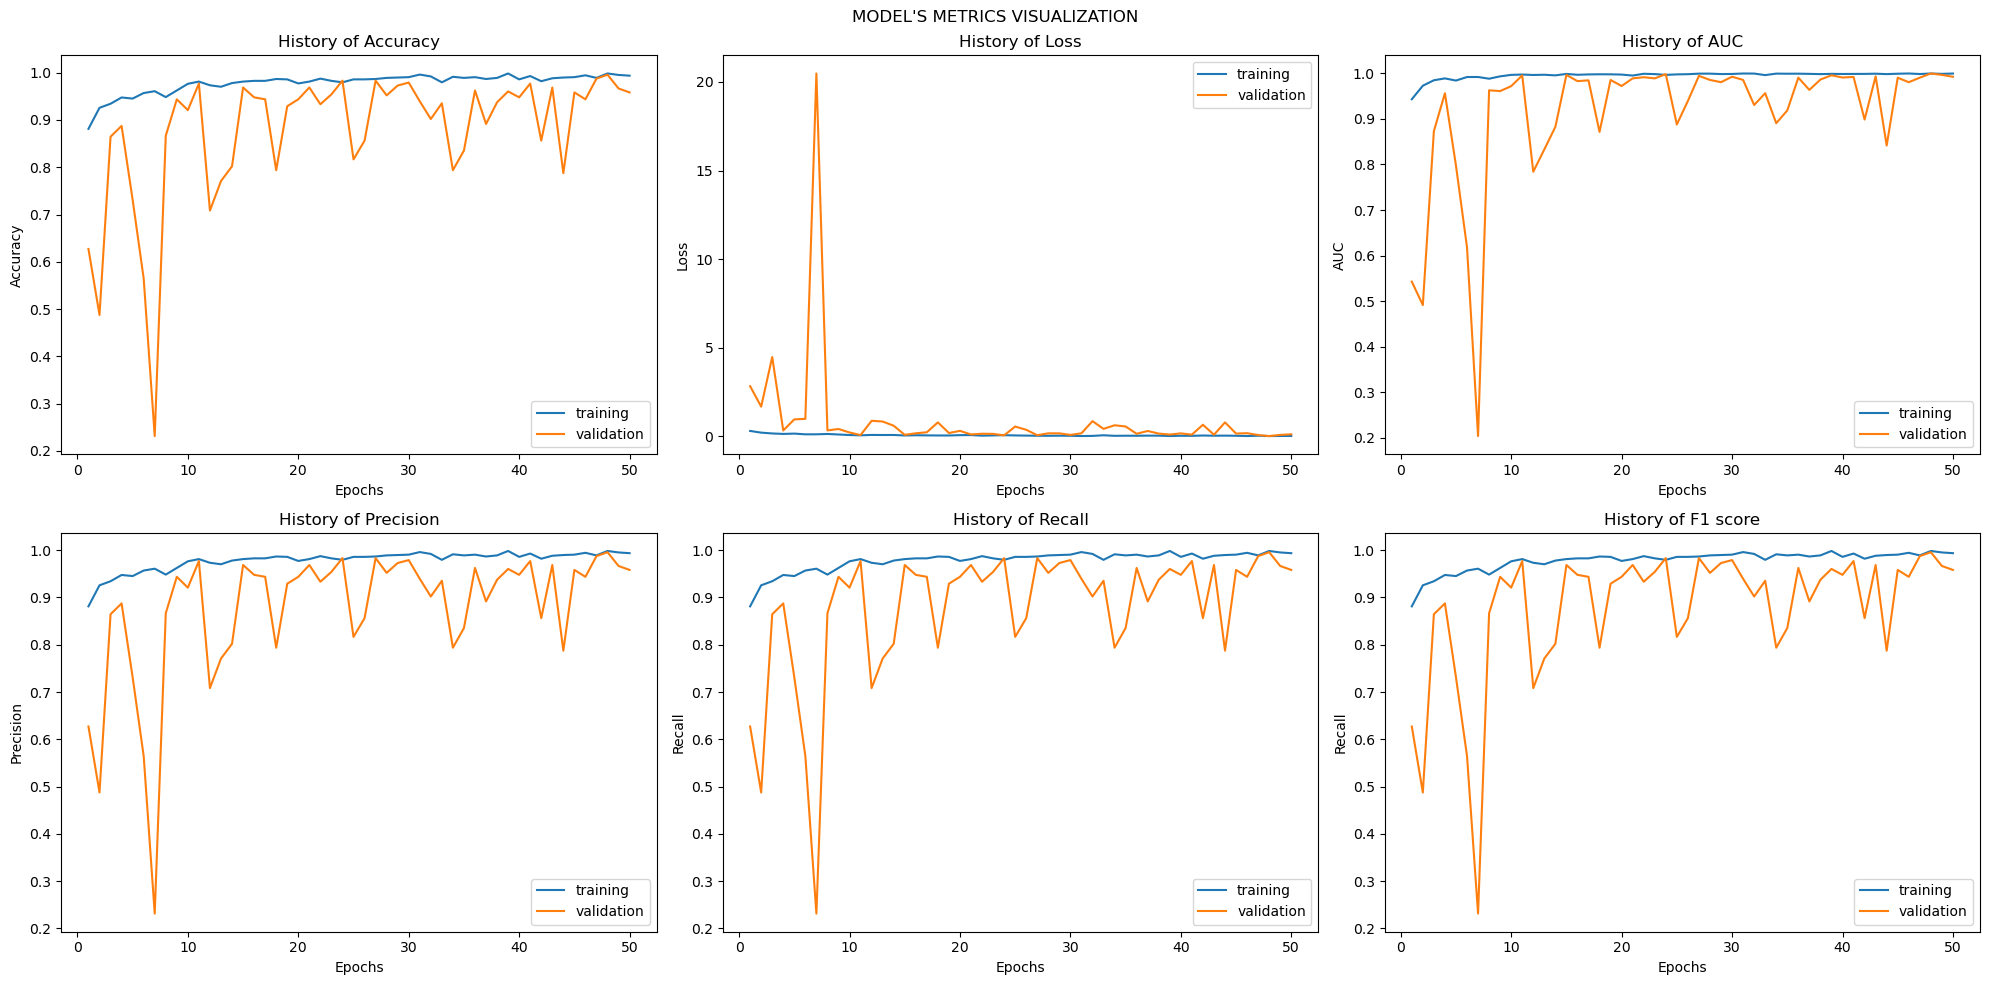

In [14]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    axes[0, 0].plot(range(1, len(acc) + 1), acc)
    axes[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axes[0, 0].set_title('History of Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(['training', 'validation'])

    axes[0, 1].plot(range(1, len(loss) + 1), loss)
    axes[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axes[0, 1].set_title('History of Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(['training', 'validation'])

    axes[0, 2].plot(range(1, len(auc) + 1), auc)
    axes[0, 2].plot(range(1, len(val_auc) + 1), val_auc)
    axes[0, 2].set_title('History of AUC')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend(['training', 'validation'])

    axes[1, 0].plot(range(1, len(precision) + 1), precision)
    axes[1, 0].plot(range(1, len(val_precision) + 1), val_precision)
    axes[1, 0].set_title('History of Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(['training', 'validation'])

    axes[1, 1].plot(range(1, len(recall) + 1), recall)
    axes[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axes[1, 1].set_title('History of Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(['training', 'validation'])

    axes[1, 2].plot(range(1, len(f1_score) + 1), f1_score)
    axes[1, 2].plot(range(1, len(val_f1_score) + 1), val_f1_score)
    axes[1, 2].set_title('History of F1 score')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Recall')  # Corrected from 'Recall' to 'F1 score'
    axes[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

# Call the function with your history data
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['recall'], history.history['val_recall'],
               history.history['f1_score'], history.history['val_f1_score'])

## Results

In [22]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class test():
    def get_filpath(self, dirname):
        test_files = []
        for x in os.walk(dirname):
            for y in glob.glob(os.path.join(x[0], '*.png')):
                test_files.append(y)

        return test_files
        
    def get_input(self, path):
        input = cv2.imread(path)
        input = cv2.resize(input, (299, 299))
        input = input.reshape(-1, 299, 299, 3)
        return input
    
    def get_output(self, path):
        labaF = [1,0]
        labaT = [0,1]
        label = (path.split('/')[7]).split('_')[0]
        #print(label)
        if 'fake' == label:
            return labaF
        else:
            return labaT

    def load_model(self, modpath):
        model.load_weights(modpath)
        return model

    def test(self, paths, modpath):
        true_label = []
        predicted = []
        features = []
        mod = self.load_model(modpath)
        modeller = K.Model(inputs=mod.get_layer(name='input_1').output,
                   outputs=mod.get_layer(name='tf.compat.v1.squeeze').output)
        positive = 0
        for path in paths:
            im = self.get_input(path)
            lab = self.get_output(path)
            
            pred_label = np.argmax(mod.predict(im))
            feat = modeller.predict(im)
            features.append(feat)
            predicted.append(pred_label)

            real_label = np.argmax(lab)
            true_label.append(real_label)
            if pred_label == real_label:
                positive = positive + 1
            #print("Filepath : {}, Predicted Label = {}, True Label = {}".format(path, pred_label, real_label))

        FPR, TPR, threshold1 = roc_curve(true_label, predicted)
        print("FPR:", FPR, "TPR:", TPR, "Threshold:", threshold1)
        aucSci = roc_auc_score(true_label, predicted)
        print('Auc score scikit: ', aucSci)
        disp = ConfusionMatrixDisplay(confusion_matrix(true_label, predicted))
        disp.plot()
        plt.show()
        return positive/len(paths), FPR, TPR, true_label, features


    def run(self, dirname, modpath):
        paths = self.get_filpath(dirname)
        random.shuffle(paths)
        res, FPR, TPR, true_label, features = self.test(paths, modpath)

        return res, FPR, TPR, true_label, features

1/1 [==============================] - 0s 25ms/step
FPR: [0.         0.00294118 1.        ] TPR: [0.         0.83707865 1.        ] Threshold: [2 1 0]
Auc score scikit:  0.9170687376074025


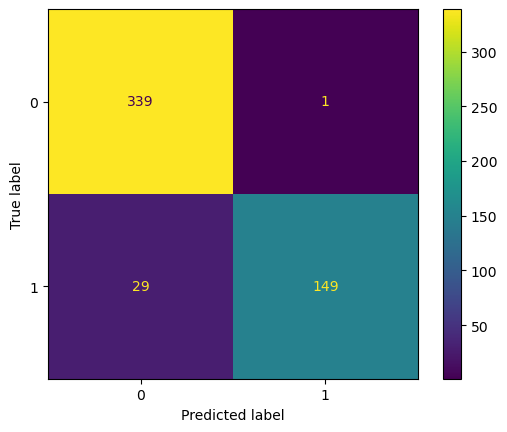

Test Accuracy = 0.9420849420849421


In [23]:
if __name__=='__main__':
    dirname = '/kaggle/input/deepfake/CelebImageDataset/Celeb Image Dataset/testImage'  #PATH OF TEST DATA DIRECTORY
    modpath = '/kaggle/working/model.hdf5'  #PATH OF TRAINED MODEL
    acc, FPR, TPR, true_label, features = test().run(dirname, modpath)
    print("Test Accuracy = {}".format(acc))

#### Heatmap

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from typing import Optional, Tuple, List

def visualize_class_activation_map(model, img_path, layer_name, thr=None, verbose=True):
    original_img = Image.open(img_path).convert('RGB')
    original_img = original_img.resize((299, 299))
    img_arr = np.array(original_img) / 255.
    width, height, _ = img_arr.shape
    cam_model = tf.keras.Model(model.input, model.get_layer(layer_name).output)
    cam = cam_model(np.array([img_arr])).numpy()[0]
    print(img_arr.shape)
    mask = np.mean(cam, axis=-1)
    mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
    print(mask.shape)
    mask_width, mask_height = mask.shape
    scaled_mask = tf.keras.layers.UpSampling2D(size=(width // mask_width, height // mask_height), interpolation="bilinear")(
        np.reshape(mask, (1, mask_width, mask_height, 1)))[0].numpy()
    print(scaled_mask.shape)
    new_shape = (290, 290, 3)
    img_arr = img_arr[:new_shape[0], :new_shape[1]]
    attentive_img = (img_arr * scaled_mask) * 255

    # Create a heatmap using 'jet' colormap
    heatmap = cm.jet(scaled_mask.squeeze())  # Squeeze the extra dimension
    return original_img, heatmap, attentive_img

def visualize_class_activation_map_for_directory(model, img_path, layer_name):
    original_img, heatmap, attentive_img = visualize_class_activation_map(model, img_path, layer_name)

    # Plot the original image and the heatmap
    plt.figure(figsize=(6, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, alpha=0.55)
    plt.title('Heatmap')

##### Fake

(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)


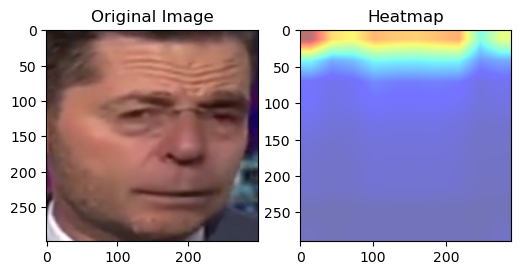

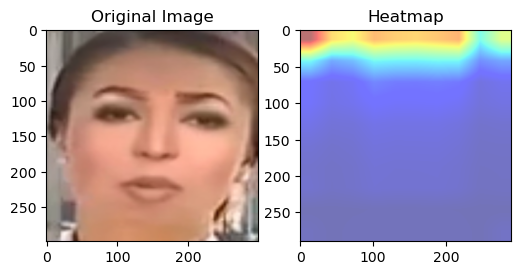

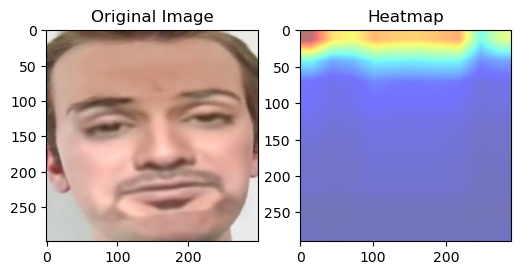

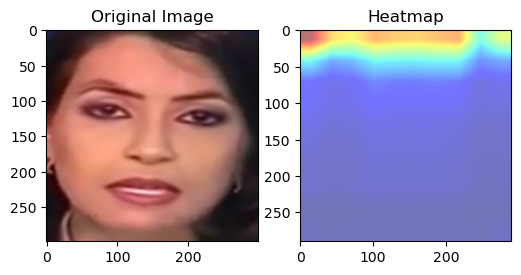

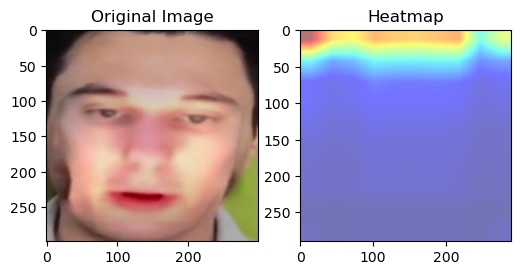

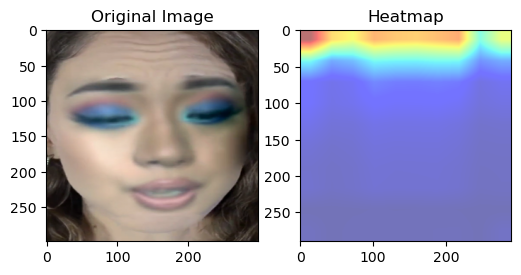

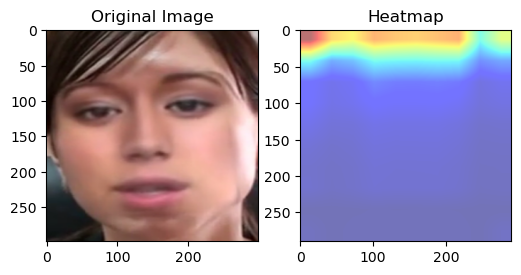

In [18]:
img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/fake_004_982_frame154.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/fake_007_132_frame252.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/fake_011_805_frame316.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/fake_029_048_frame208.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/fake_044_945_frame167.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/fake_045_889_frame175.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/fake_049_946_frame180.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

##### Real

(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)
(299, 299, 3)
(10, 10)
(290, 290, 1)


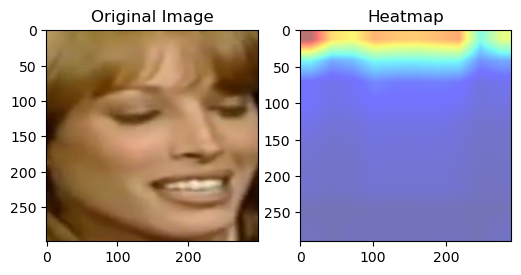

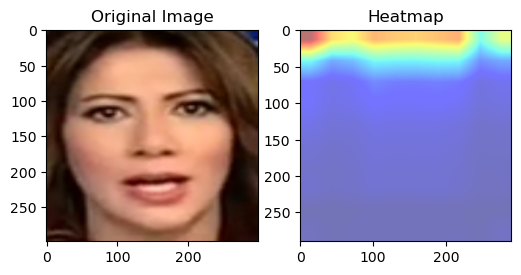

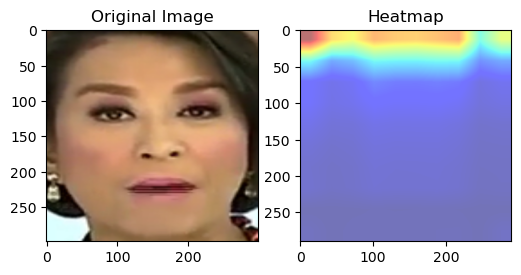

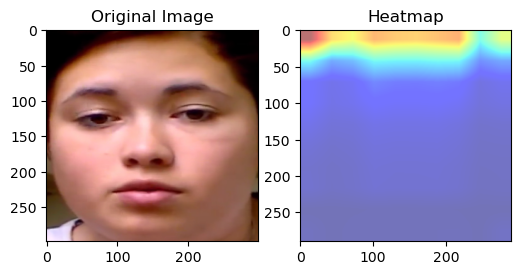

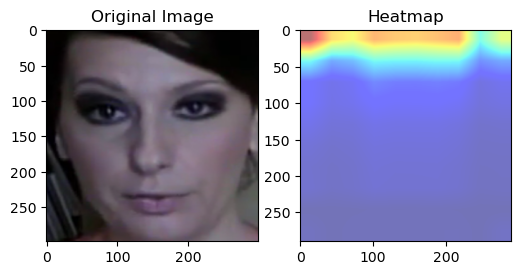

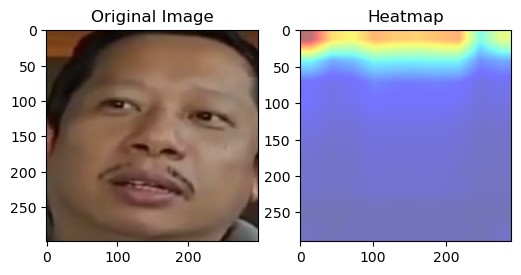

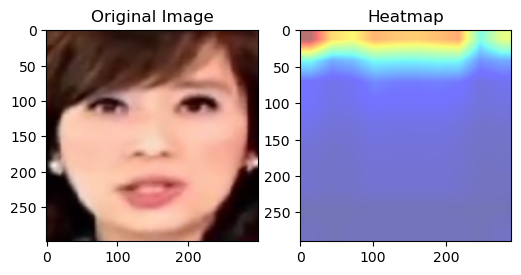

In [19]:
img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/real_999_frame167.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/real_969_frame178.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/real_962_frame230.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/real_957_frame209.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/real_944_frame171.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/real_938_frame184.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

img_path = '/kaggle/input/deepfake/FaceForensic/FaceForensic/test/real_930_frame224.png'
layer_name = 'block14_sepconv2_act'  

visualize_class_activation_map_for_directory(model, img_path, layer_name)

#### Subspace

##### GAP layer

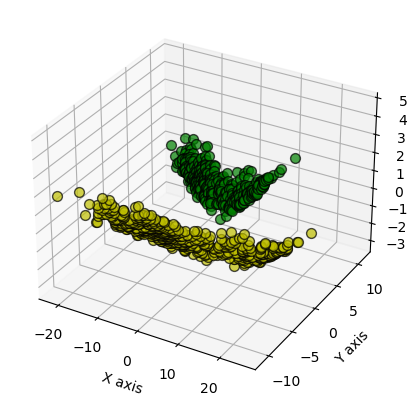

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the number of classes and the range for 'j'
num_classes = 2
j_range = range(518)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Define colors for different classes
colors = ['g', 'y']

# Set the size and alpha for the points
point_size = 50
point_alpha = 1.0
opacity = 0.7
border_width = 1

# Create a PCA object with 3 components
pca = PCA(n_components=3)

# Ensure correct dimensions of features (check and reshape if needed)
if np.asarray(features).ndim > 2:
    features = np.asarray(features).reshape(-1, 512)  # Replace 1024 with actual feature count

# Apply PCA to the entire features array once
features_pca = pca.fit_transform(features)

for i in range(features_pca.shape[0]):
    class_indices = np.where(true_label == i)[0]
    current_color = colors[i % len(colors)]
    ax.scatter(features_pca[i, 0], features_pca[i, 1], features_pca[i, 2],
               c=current_color, marker='o', s=point_size, alpha=opacity,
               edgecolor='black', linewidth=border_width)

# Set axis labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

##### Dense layer

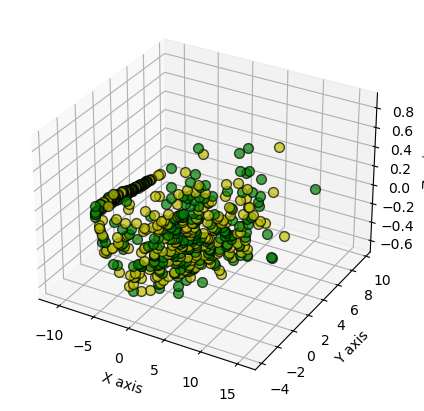

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the number of classes and the range for 'j'
num_classes = 2
j_range = range(518)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Define colors for different classes
colors = ['g', 'y']

# Set the size and alpha for the points
point_size = 50
point_alpha = 1.0
opacity = 0.7
border_width = 1

# Create a PCA object with 3 components
pca = PCA(n_components=3)

# Ensure correct dimensions of features (check and reshape if needed)
if np.asarray(features).ndim > 2:
    features = np.asarray(features).reshape(-1, 512)  # Replace 1024 with actual feature count

# Apply PCA to the entire features array once
features_pca = pca.fit_transform(features)

for i in range(features_pca.shape[0]):
    class_indices = np.where(true_label == i)[0]
    current_color = colors[i % len(colors)]
    ax.scatter(features_pca[i, 0], features_pca[i, 1], features_pca[i, 2],
               c=current_color, marker='o', s=point_size, alpha=opacity,
               edgecolor='black', linewidth=border_width)

# Set axis labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()